<a href="https://colab.research.google.com/github/shellylin100/NLP-useful-function/blob/main/Evaluated_Exercise_4_Part_1_s0572048.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Evaluated Exercise Part 4 – Natural Language Processing

Please run the task in a jupyter notebook (e.g. in Google Colab or a Virtual Machine or ...)
You are working as Data Scientist for a large hotel company called Daccor. The company wants to automize the analysis of customer surveys.

**Part 1: Topic Model based on customer reviews [10%]**

Context
Please analyze the customer reviews and try to find relevant topics in the reviews, so that an automized reporting system can be implemented to analyze the reviews in close to real time.
- **What is the optimal number of topics?**
- Please describe the topics


# 1. Package Handling

In [5]:
#!pip install pyLDAvis
#!pip install gensim --upgrade

     |████████████████████████████████| 1.7MB 3.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.0.0-py2.py3-none-any.whl size=136704 sha256=965de08a4a52e069e456a300a4938161da2f0f11b7ec4eb9fb9442ee44363796
  Stored in directory: /root/.cache/pip/wheels/e8/6d/d3/85bc954f74554c8ee9bb6e7d03dcf2c1ec1a05526979a8389f
Successfully built pyLDAvis


In [7]:
# import nltk and spacy
import nltk
import spacy

# load nlp model from spaCy, English language
nlp = spacy.load("en")

# regular expressions
# to check for certain patterns in text (sed, grep,..)
import re
# Scikit-learn package to handle the data
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim to do the LDA models (topicmodels)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Import spaCy for Lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

# 2. Pre-requesities - Download nltk stopwords and spacy model

In [8]:
# Download stopwords from nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("Original number of stopwords:",len(stop_words))
stop_words.extend(['from','subject','re','edu','use'])

Original number of stopwords: 179


In [10]:
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [11]:
# extended number of stopwords
print("Extended number of stopwords:", len(stop_words))

Extended number of stopwords: 184


# 3. Data IO

In [12]:
# Upload the file from the local drive
from google.colab import files
uploaded = files.upload()

Saving hotelSatisfaction_English.xlsx to hotelSatisfaction_English.xlsx


In [13]:
df = pd.read_excel("hotelSatisfaction_English.xlsx")

In [14]:
df.head(5)

,Comments,OverallSentiment
0,Rooms were clean.,positive
1,Excellent value for money,positive
2,Parking too small. No free wifi in rooms. No c...,negative
3,"Comfortable rooms, outstanding breakfast, nice...",positive
4,Quiet location right on the beach.,positive


In [15]:
df.info() # There are 860 comments

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Comments          860 non-null    object
 1   OverallSentiment  860 non-null    object
dtypes: object(2)
memory usage: 13.6+ KB


In [16]:
# Positive and negative overall sentiment
len(df.OverallSentiment.unique())

2

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


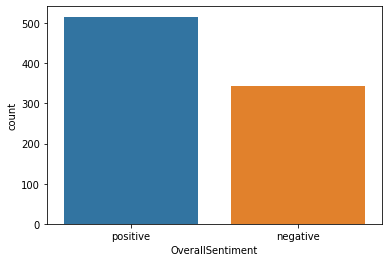

In [17]:
sns.countplot(df['OverallSentiment'])

# 4. Tokenize words into a list of words and remove the punctuations

In [18]:
# Convert Comments column data into list
data = df.Comments.values.tolist()

In [19]:
pprint(data[1:4])

['Excellent value for money',
 'Parking too small. No free wifi in rooms. No crib for our child.',
 'Comfortable rooms, outstanding breakfast, nice service']


In [20]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))

In [21]:
data_words = list(sent_to_words(data))

In [22]:
pprint(data_words[:5])

[['rooms', 'were', 'clean'],
 ['excellent', 'value', 'for', 'money'],
 ['parking',
  'too',
  'small',
  'no',
  'free',
  'wifi',
  'in',
  'rooms',
  'no',
  'crib',
  'for',
  'our',
  'child'],
 ['comfortable', 'rooms', 'outstanding', 'breakfast', 'nice', 'service'],
 ['quiet', 'location', 'right', 'on', 'the', 'beach']]


## Remove stopwords

In [23]:
def remove_stopwords(texts):
  return[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [24]:
data_words_nostops = remove_stopwords(data_words)

In [25]:
# were is a stop words so it's removed
data_words_nostops[:1]

[['rooms', 'clean']]

## Lamatization
- Use spaCy  
- Transform the text into a "doc" using ulp() function

In [26]:
def lemmatization(texts, allowed_postags = ['NOUN','ADJ','VERB','ADV']):
  texts_out = []
  for sent in texts:
    doc = nlp(" ".join(sent))
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return texts_out

In [27]:
# Do lemmatization keep NOUN, ADJ, VERB, ADV:
data_lemmatized = lemmatization(texts = data_words_nostops, allowed_postags = ['NOUN','ADJ','VERB','ADV'])

In [28]:
pprint(data_lemmatized[1:2])

[['excellent', 'value', 'money']]


## Create the dictionary and Corpus needed for Topic Modeling
2 main inputs for LDA topic model are the **dictionary (id2word)** and the **corpus**

In [29]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [30]:
# Create Corpus
texts = data_lemmatized

In [31]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts ]

Gensim creates a unique id for each word in the document.   
The produced corpus shown above is a mapping of [word_id, word_frequency] 

ex : word id 0 occurs once in the first document. 

In [32]:
# View created corpus
pprint(corpus[:3])

[[(0, 1), (1, 1)],
 [(2, 1), (3, 1), (4, 1)],
 [(1, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]


In [33]:
id2word[2]

'excellent'

In [34]:
# Make a human-readable of the corpus
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('clean', 1), ('room', 1)], [('excellent', 1), ('money', 1), ('value', 1)]]

# 5. Build the baseline topic model
- Need Corpus, Dictionary
- Need provide the number of topics
- Hyperparameters : alpha, eta (default = 1.0/num_topics)
- chunksize : the number of documents to be used in each training chunk
- update_every : determines how often the model parameters should be updated
- passes : total number of training passes

In [35]:
# Build the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = 20,
                                            random_state = 100,
                                            update_every = 1, 
                                            chunksize = 100, 
                                            passes = 10,
                                            alpha = 'auto',
                                            per_word_topics = True)

lda_model trained above is built with **20** different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.
- You can see the keywords for each topic and the weightage[importance] of each keyword using lda_model.print_topics()

In [36]:
# Print the keywords in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.224*"comfortable" + 0.083*"room" + 0.076*"breakfast" + 0.049*"wireless" + '
  '0.049*"ready" + 0.034*"last" + 0.034*"disappointed" + 0.034*"expenseive" + '
  '0.019*"stylish" + 0.018*"week"'),
 (1,
  '0.395*"great" + 0.247*"good" + 0.067*"price" + 0.034*"soundproof" + '
  '0.024*"ratio" + 0.023*"performance" + 0.021*"high" + 0.016*"design" + '
  '0.013*"rather" + 0.011*"real"'),
 (2,
  '0.121*"expensive" + 0.091*"love" + 0.057*"quiet" + 0.031*"best" + '
  '0.031*"bedding" + 0.031*"comfy" + 0.031*"ever" + 0.031*"avoid" + '
  '0.031*"acknowledgement" + 0.031*"status"'),
 (3,
  '0.112*"extremely" + 0.074*"guest" + 0.058*"time" + 0.049*"early" + '
  '0.046*"find" + 0.045*"professional" + 0.040*"wait" + 0.038*"unfortunately" '
  '+ 0.035*"treatment" + 0.035*"wife"'),
 (4,
  '0.378*"hotel" + 0.080*"average" + 0.058*"quality" + 0.051*"child" + '
  '0.024*"need" + 0.022*"many" + 0.019*"renovation" + 0.017*"fine" + '
  '0.013*"restoration" + 0.013*"tired"'),
 (5,
  '0.224*"helpful" + 

# 6. Compute Model Preplexity and Coherence Score
- it provides a convenient measure to judge how good a given topic model is. 
- it seems topic coherence score is quite helpful for topic modeling
- Perplexity is to measure how good the model is. the lower the better

In [37]:
# Compute Perplexity
print('\nPerplexity:', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)


Perplexity: -6.228800603217287

Coherence Score: 0.5787763533751612


## Visualize the topics-keywords

In [38]:
# Visualize the topics
pyLDAvis.enable_notebook() # initialize
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.176986 -0.364126       1        1  12.402921
7      0.322659 -0.156759       2        1   9.281485
1     -0.095389 -0.080158       3        1   8.558119
14    -0.073241 -0.007028       4        1   6.196575
4     -0.045588  0.042541       5        1   5.789743
5     -0.059560  0.017470       6        1   5.672034
13     0.042306 -0.044905       7        1   5.395555
12    -0.070894 -0.023545       8        1   5.320649
17    -0.039863  0.047496       9        1   4.747172
16    -0.043993  0.043261      10        1   4.609184
6      0.193548 -0.029769      11        1   4.539964
11    -0.021943  0.030020      12        1   4.476304
18    -0.006780  0.079274      13        1   3.487878
19    -0.028222  0.061527      14        1   3.301819
8     -0.002575  0.092747      15        1   3.087320
3     -0.024811  0.088809      16        1   2.973879
2     -0.029039  0.065737      17        1   2.759172
0      0.172107 -0.006005      18        1   2.629593
9      0.003661  0.066506      19        1   2.445834
10    -0.015397  0.076906      20        1   2.324800, topic_info=            Term        Freq       Total Category  logprob  loglift
1           room  148.000000  148.000000  Default  30.0000  30.0000
28         staff  115.000000  115.000000  Default  29.0000  29.0000
66         great   86.000000   86.000000  Default  28.0000  28.0000
33         hotel   56.000000   56.000000  Default  27.0000  27.0000
26      friendly   75.000000   75.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
25     excursion    0.236627    0.961944  Topic20  -5.5157   2.3591
27      offering    0.236627    0.961944  Topic20  -5.5157   2.3591
119         home    0.236627    0.961944  Topic20  -5.5157   2.3591
120  immediately    0.236627    0.961944  Topic20  -5.5157   2.3591
150  environment    0.236627    0.961944  Topic20  -5.5157   2.3591

[693 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
115      10  0.450411     absolutely
256       6  0.933391         access
421       1  0.664757    accomdating
117       6  0.778932    accommodate
112       8  0.669803  accommodating
...     ...       ...            ...
40        7  0.959569      wonderful
198       4  0.896609           work
404      17  0.453793        working
107      20  0.647632          would
555      12  0.896075           year

[473 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 8, 2, 15, 5, 6, 14, 13, 18, 17, 7, 12, 19, 20, 9, 4, 3, 1, 10, 11])

# 7. Find the optimal number of topics for LDA model

In [39]:
def compute_coherence_values(dictionary, corpus, texts, limit=11, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                                id2word = id2word,
                                                num_topics = num_topics,
                                                random_state = 100,
                                                #update_every = 1, 
                                                chunksize = 100, 
                                                passes = 10,
                                                alpha = 'auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [40]:
# Run the model (take a long time)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus = corpus, 
                                                        texts = data_lemmatized, 
                                                        start=2, 
                                                        limit=11,
                                                        step = 1)

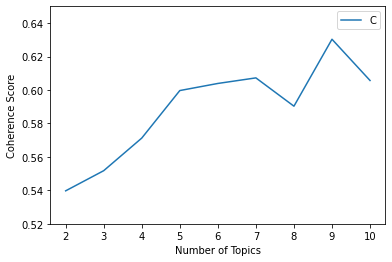

In [41]:
# show graph of different coherence score
limit = 11; start = 2; step = 1;
x = range(start, limit, step)
plt.ylim(0.52, 0.65)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("Coherence_values"), loc = 'best')
plt.show()

For our model, it seems the num_topics = 9 creates the highest coherence score. We will choose **9 topics** for our number of topics

In [42]:
# print the coherence scores
for m, cv in zip(x, coherence_values):
  print("Num_topics = ", m, " has coherence values of ", round(cv, 5))

Num_topics =  2  has coherence values of  0.53971
Num_topics =  3  has coherence values of  0.55176
Num_topics =  4  has coherence values of  0.57125
Num_topics =  5  has coherence values of  0.59966
Num_topics =  6  has coherence values of  0.60391
Num_topics =  7  has coherence values of  0.60724
Num_topics =  8  has coherence values of  0.59032
Num_topics =  9  has coherence values of  0.63034
Num_topics =  10  has coherence values of  0.60568


# 8. Obtain the final Model and its Results to observe the possible topics

In [45]:
final_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                               id2word = id2word,
                                               num_topics = 9,
                                               random_state = 100,
                                               update_every = 1,
                                               chunksize = 100, 
                                               passes = 10,
                                               alpha = 'auto',
                                               per_word_topics = True)

In [46]:
# Print topics
pprint(final_model.print_topics())

[(0,
  '0.297*"room" + 0.077*"service" + 0.068*"clean" + 0.042*"internet" + '
  '0.039*"outstanding" + 0.038*"breakfast" + 0.028*"small" + 0.025*"access" + '
  '0.024*"wonderful" + 0.016*"comfortable"'),
 (1,
  '0.202*"good" + 0.073*"stay" + 0.055*"price" + 0.044*"location" + '
  '0.041*"poor" + 0.039*"restaurant" + 0.028*"soundproof" + 0.020*"food" + '
  '0.020*"ratio" + 0.019*"performance"'),
 (2,
  '0.094*"bad" + 0.073*"staff" + 0.061*"bathroom" + 0.049*"expensive" + '
  '0.038*"employee" + 0.035*"dirty" + 0.025*"tiny" + 0.023*"quiet" + '
  '0.021*"smelly" + 0.019*"courteous"'),
 (3,
  '0.169*"hotel" + 0.036*"average" + 0.032*"love" + 0.032*"reservation" + '
  '0.031*"back" + 0.029*"come" + 0.024*"expect" + 0.024*"shuttle" + '
  '0.023*"never" + 0.022*"lose"'),
 (4,
  '0.258*"great" + 0.059*"food" + 0.051*"free" + 0.046*"facility" + '
  '0.038*"always" + 0.037*"experience" + 0.028*"location" + 0.022*"child" + '
  '0.022*"available" + 0.019*"beautiful"'),
 (5,
  '0.123*"excellent" + 

# 9. Describe the topics of final model
- Topic 1 : **The Room**
- Topic 2 : **What's "good" for customer?**
- Topic 3 : **What's "bad" for customer?**
- Topic 4 : **The hotel service**
- Topic 5 : **What's "great" for customer?**
- Topic 6 : **What's "excellent" for customer?**
- Topic 7 : **The bed**
- Topic 8 : **Cleanness**
- Topic 9 : **The staff**

In [47]:
pip install nbconvert